In [1]:
%load_ext autoreload
%autoreload 2

# ignore imputation warnings from pymc
# ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
import warnings
from pymc import ImputationWarning

warnings.filterwarnings("ignore", category=ImputationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [37]:
from birdcall_distribution.data import prepare_dataframe
import pandas as pd

taxonomy_df = pd.read_csv(
    "https://storage.googleapis.com/birdclef-eda-f22/data/raw/birdclef-2022/eBird_Taxonomy_v2021.csv"
)
taxonomy_df.columns = taxonomy_df.columns.str.lower()
species_mapper = taxonomy_df.set_index("species_code")["primary_com_name"].to_dict()

prep_df, W = prepare_dataframe(
    "../data/ee_v3_western_us_2.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=3,
)

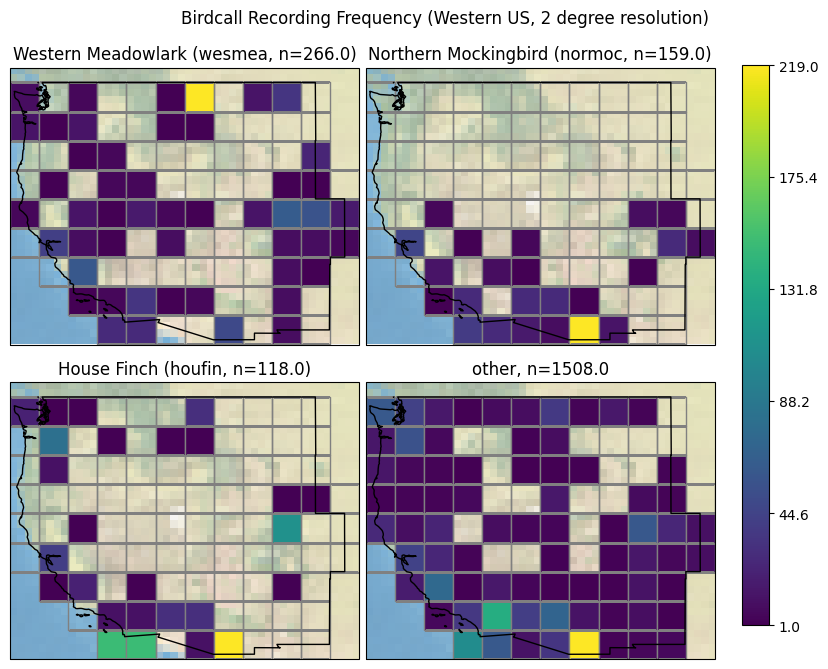

In [78]:
import matplotlib.pyplot as plt
from birdcall_distribution.plot import plot_species_subplot
import numpy as np

# grid size
grid_size = prep_df.grid_size.values[0]

# sorted list of records
species = list(
    prep_df[prep_df.primary_label != "other"]
    .groupby("primary_label")
    .sum(numeric_only=True)
    .y.sort_values(ascending=False)
    .index
)
plot_species_subplot(
    prep_df,
    species + ["other"],
    prop="y",
    subtitle=f"Western US, {grid_size} degree resolution",
    species_mapper=species_mapper,
)
plt.show()

In [92]:
from birdcall_distribution import model
import pymc as pm
import arviz as az

m1 = model.make_varying_intercept_varying_covariate_car_model(prep_df, W)
with m1:
    trace1 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

Multiprocess sampling (16 chains in 16 jobs)
CompoundStep
>NUTS: [alpha, sigma_phi, phi, intercept_bar, intercept_sigma, intercept, betas_bar, betas_sigma, betas]
>Metropolis: [y_missing]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 319 seconds.


In [72]:
with m1:
    # posterior predictive
    ppc1 = pm.sample_posterior_predictive(trace1)

Sampling: [y_observed]


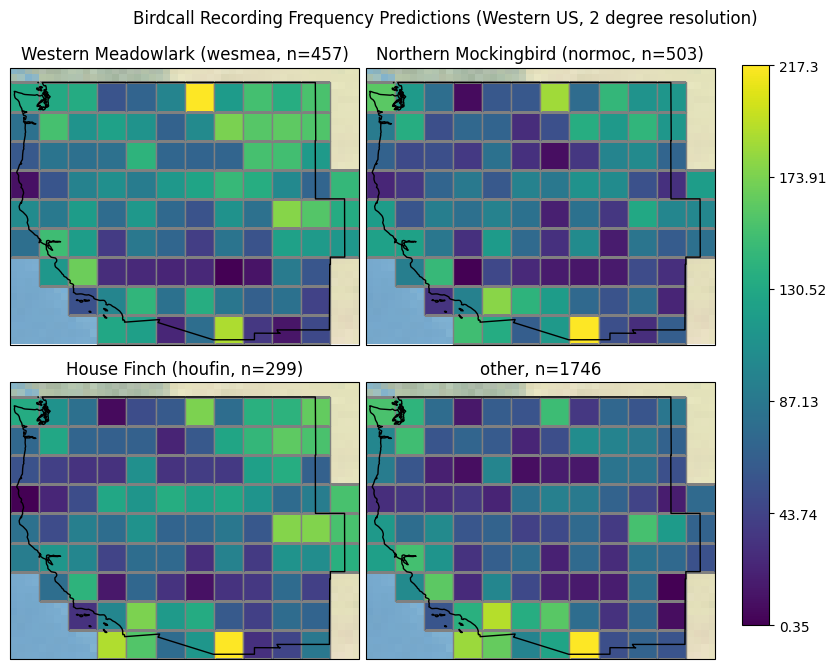

In [91]:
from birdcall_distribution.plot import plot_ppc_species_subplot

plot_ppc_species_subplot(
    prep_df,
    ppc1,
    species + ["other"],
    prop="pred",
    species_mapper=species_mapper,
    subtitle=f"Western US, {grid_size} degree resolution",
)
plt.show()